<a href="https://colab.research.google.com/github/wilmerpascual/Napier_Grass/blob/main/MultiClass_InceptionV3_Napiergrass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ======================== #
#      IMPORT LIBRARIES    #
# ======================== #

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import matplotlib.gridspec as gridspec
import random


# ======================== #
#     MOUNT GOOGLE DRIVE   #
# ======================== #

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ======================== #
#      CONFIGURATION       #
# ======================== #

In [ ]:
dataset_path = '/content/drive/MyDrive/the_dataset_napiergrass/napiergrass'
output_folder = '/content/output'
BATCH_SIZE = 32
IMAGE_SIZE = (299, 299)  # InceptionV3 default size
EPOCHS_HEAD = 25       # Epochs para sa training ng custom head
EPOCHS_FINE_TUNE = 10  # Additional epochs para sa fine-tuning
CLASS_NAMES = [
    "bacterial_leaf_streak", "brown_spot", "cercospora", "curvularia_leaf_spot", "eyespot",
    "fungal_blast",  "helminthosporium_leaf_spot", "leaf_blight", "leaf_streak",
    "narrow_brown_leaf_spot", "planthopper", "stem_borer", "healthy"
]



# ======================== #
#    DATA PREPARATION      #
# ======================== #

In [ ]:
# I-install at i-import ang split-folders
!pip install split-folders
import splitfolders

# Hatiin ang dataset sa train/val/test (80/10/10)
splitfolders.ratio(
    dataset_path,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.10, 0.10),
    group_prefix=None,
    move=False
)

Copying files: 4162 files [04:27, 15.59 files/s]


# ======================== #
#      DATA GENERATORS     #
# ======================== #

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f'{output_folder}/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    classes=CLASS_NAMES,
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    f'{output_folder}/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    classes=CLASS_NAMES,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    f'{output_folder}/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    classes=CLASS_NAMES,
    shuffle=False
)


Found 3327 images belonging to 13 classes.
Found 416 images belonging to 13 classes.
Found 417 images belonging to 13 classes.


# ======================== #
#  HANDLE CLASS IMBALANCE  #
# ======================== #

In [ ]:
class_counts = train_generator.classes
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(class_counts),
    y=class_counts
)
class_weights = dict(enumerate(class_weights))



# ======================== #
#    PRE-TRAINED MODEL     #
# ======================== #

In [ ]:
# Load InceptionV3 nang walang top layers
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3)
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# I-freeze ang base model para sa initial training
base_model.trainable = False
# Gumawa ng custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



In [ ]:
# I-compile ang model para sa initial training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 23,914,285 (91.23 MB)

 Trainable params: 2,111,501 (8.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

# ======================== #
#   MODEL TRAINING (HEAD)  #
# ======================== #

In [ ]:
# Callbacks para sa initial training
callbacks_head = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model_head.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]


In [ ]:

history_head = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks_head,
    class_weight=class_weights
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0932 - loss: 2.6981

103/103 ━━━━━━━━━━━━━━━━━━━━ 542s 5s/step - accuracy: 0.0933 - loss: 2.6976 - val_accuracy: 0.1562 - val_loss: 2.4529 - learning_rate: 5.0000e-06
Epoch 2/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.0625 - loss: 2.5668

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 399ms/step - accuracy: 0.0625 - loss: 2.5668 - val_accuracy: 0.1587 - val_loss: 2.4515 - learning_rate: 5.0000e-06
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1450 - loss: 2.5126

103/103 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.1452 - loss: 2.5122 - val_accuracy: 0.2644 - val_loss: 2.3207 - learning_rate: 5.0000e-06
Epoch 4/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.1875 - loss: 2.3260

103/103 ━━━━━━━━━━━━━━━━━━━━ 40s 388ms/step - accuracy: 0.1875 - loss: 2.3260 - val_accuracy: 0.2668 - val_loss: 2.3193 - learning_rate: 5.0000e-06
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1990 - loss: 2.3682

103/103 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.1991 - loss: 2.3680 - val_accuracy: 0.3678 - val_loss: 2.1963 - learning_rate: 5.0000e-06
Epoch 6/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.3125 - loss: 2.2773

103/103 ━━━━━━━━━━━━━━━━━━━━ 39s 380ms/step - accuracy: 0.3125 - loss: 2.2773 - val_accuracy: 0.3726 - val_loss: 2.1951 - learning_rate: 5.0000e-06
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2526 - loss: 2.2807

103/103 ━━━━━━━━━━━━━━━━━━━━ 448s 4s/step - accuracy: 0.2527 - loss: 2.2803 - val_accuracy: 0.4856 - val_loss: 2.0819 - learning_rate: 5.0000e-06
Epoch 8/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.2812 - loss: 2.1199

103/103 ━━━━━━━━━━━━━━━━━━━━ 38s 370ms/step - accuracy: 0.2812 - loss: 2.1199 - val_accuracy: 0.4856 - val_loss: 2.0809 - learning_rate: 5.0000e-06
Epoch 9/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3124 - loss: 2.1432

103/103 ━━━━━━━━━━━━━━━━━━━━ 455s 4s/step - accuracy: 0.3127 - loss: 2.1429 - val_accuracy: 0.5457 - val_loss: 1.9731 - learning_rate: 5.0000e-06
Epoch 10/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.3750 - loss: 2.1099

103/103 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.3750 - loss: 2.1099 - val_accuracy: 0.5457 - val_loss: 1.9721 - learning_rate: 5.0000e-06
Epoch 11/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3724 - loss: 2.0350

103/103 ━━━━━━━━━━━━━━━━━━━━ 447s 4s/step - accuracy: 0.3725 - loss: 2.0348 - val_accuracy: 0.6178 - val_loss: 1.8741 - learning_rate: 5.0000e-06
Epoch 12/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.5312 - loss: 1.8516

103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 361ms/step - accuracy: 0.5312 - loss: 1.8516 - val_accuracy: 0.6178 - val_loss: 1.8733 - learning_rate: 5.0000e-06
Epoch 13/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4122 - loss: 1.9405

103/103 ━━━━━━━━━━━━━━━━━━━━ 447s 4s/step - accuracy: 0.4123 - loss: 1.9403 - val_accuracy: 0.6562 - val_loss: 1.7838 - learning_rate: 5.0000e-06
Epoch 14/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.2812 - loss: 1.9523

103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 366ms/step - accuracy: 0.2812 - loss: 1.9523 - val_accuracy: 0.6562 - val_loss: 1.7831 - learning_rate: 5.0000e-06
Epoch 15/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4499 - loss: 1.8564

103/103 ━━━━━━━━━━━━━━━━━━━━ 458s 4s/step - accuracy: 0.4500 - loss: 1.8561 - val_accuracy: 0.6899 - val_loss: 1.7005 - learning_rate: 5.0000e-06
Epoch 16/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.4688 - loss: 1.9883

103/103 ━━━━━━━━━━━━━━━━━━━━ 39s 380ms/step - accuracy: 0.4688 - loss: 1.9883 - val_accuracy: 0.6899 - val_loss: 1.6998 - learning_rate: 5.0000e-06
Epoch 17/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4818 - loss: 1.7791

103/103 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step - accuracy: 0.4818 - loss: 1.7790 - val_accuracy: 0.7115 - val_loss: 1.6229 - learning_rate: 5.0000e-06
Epoch 18/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.5312 - loss: 1.6396

103/103 ━━━━━━━━━━━━━━━━━━━━ 39s 383ms/step - accuracy: 0.5312 - loss: 1.6396 - val_accuracy: 0.7115 - val_loss: 1.6219 - learning_rate: 5.0000e-06
Epoch 19/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4881 - loss: 1.7150

103/103 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.4883 - loss: 1.7148 - val_accuracy: 0.7356 - val_loss: 1.5526 - learning_rate: 5.0000e-06
Epoch 20/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.6250 - loss: 1.5034

103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.6250 - loss: 1.5034 - val_accuracy: 0.7332 - val_loss: 1.5518 - learning_rate: 5.0000e-06
Epoch 21/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5388 - loss: 1.6337

103/103 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.5389 - loss: 1.6335 - val_accuracy: 0.7428 - val_loss: 1.4844 - learning_rate: 5.0000e-06
Epoch 22/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.4375 - loss: 1.7419

103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 364ms/step - accuracy: 0.4375 - loss: 1.7419 - val_accuracy: 0.7428 - val_loss: 1.4839 - learning_rate: 5.0000e-06
Epoch 23/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5528 - loss: 1.5663

103/103 ━━━━━━━━━━━━━━━━━━━━ 445s 4s/step - accuracy: 0.5529 - loss: 1.5661 - val_accuracy: 0.7572 - val_loss: 1.4234 - learning_rate: 5.0000e-06
Epoch 24/25
  1/103 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.6562 - loss: 1.3673

103/103 ━━━━━━━━━━━━━━━━━━━━ 38s 366ms/step - accuracy: 0.6562 - loss: 1.3673 - val_accuracy: 0.7572 - val_loss: 1.4230 - learning_rate: 5.0000e-06
Epoch 25/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6012 - loss: 1.4980

103/103 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.6011 - loss: 1.4979 - val_accuracy: 0.7644 - val_loss: 1.3671 - learning_rate: 5.0000e-06


# ======================== #
#      FINE-TUNING         #
# ======================== #

In [ ]:
# Unfreeze last 20 layers only
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Simple callbacks
callbacks_fine = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
]

# Fewer epochs for faster training
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks_fine,
    class_weight=class_weights
)

Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 521s 5s/step - accuracy: 0.8099 - loss: 0.7809 - val_accuracy: 0.8822 - val_loss: 0.5872
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 494s 5s/step - accuracy: 0.8425 - loss: 0.6844 - val_accuracy: 0.8942 - val_loss: 0.5237
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 467s 4s/step - accuracy: 0.8488 - loss: 0.6384 - val_accuracy: 0.9183 - val_loss: 0.4620
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.8608 - loss: 0.5797 - val_accuracy: 0.9255 - val_loss: 0.4152
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 465s 4s/step - accuracy: 0.8899 - loss: 0.4983 - val_accuracy: 0.9351 - val_loss: 0.3759
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - accuracy: 0.8849 - loss: 0.4964 - val_accuracy: 0.9471 - val_loss: 0.3369
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.9095 - loss: 0.4322 - val_accuracy: 0.9423 - val_loss: 0.3117
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.9061 - loss: 0.3978 - val_accu

# ======================== #
#     MODEL EVALUATION     #
# ======================== #

In [ ]:
# Predict sa test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = test_generator.classes  # True labels

# Calculate metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print('InceptionV3 Model')
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')



14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step
InceptionV3 Model
Test Accuracy: 94.00%
Precision: 94.20%
Recall: 94.00%
F1 Score: 94.00%


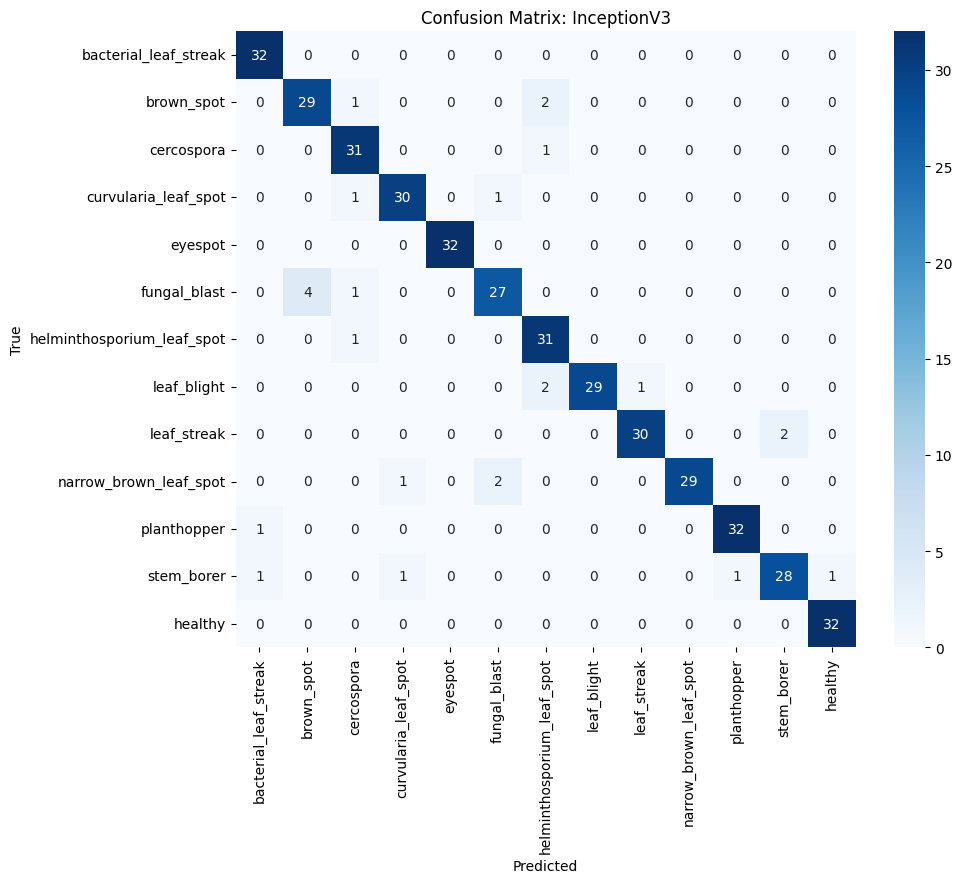

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: InceptionV3')
plt.show()


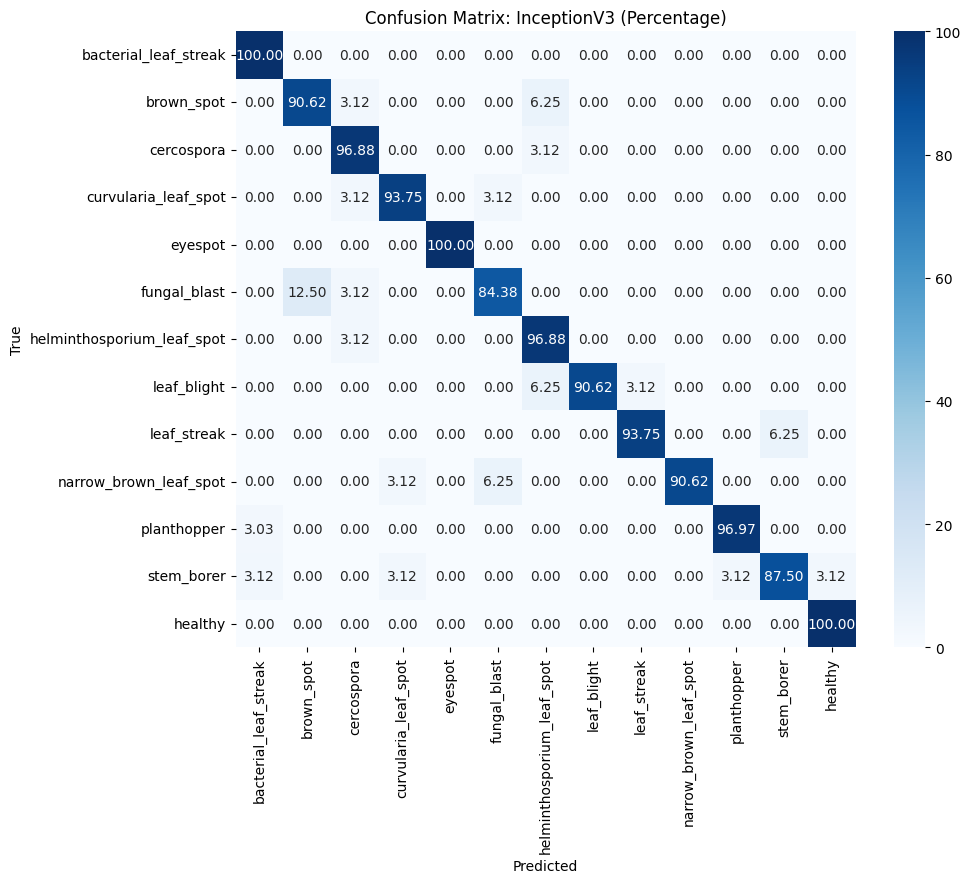

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: InceptionV3 (Percentage)')
plt.show()

In [ ]:
# Evaluate sa test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc * 100:.2f}%')


14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9488 - loss: 0.2376

Test Accuracy: 94.00%


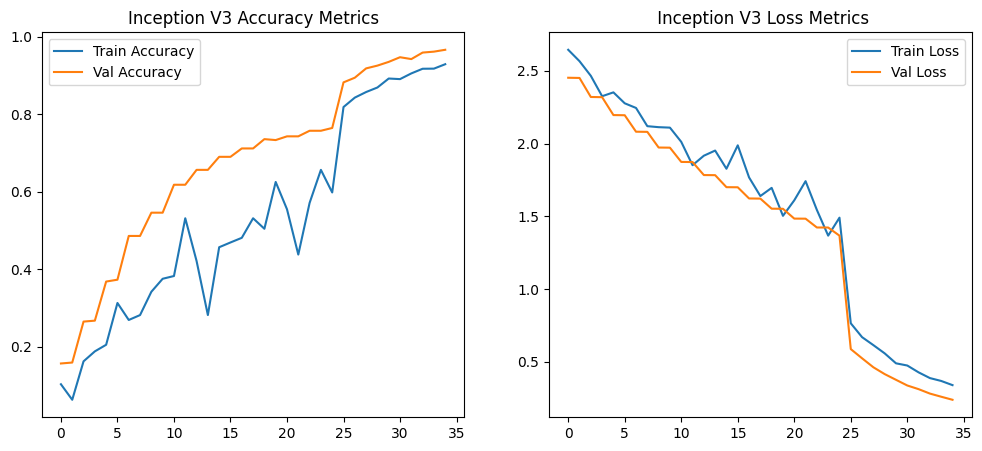

In [ ]:
# Plot training history para sa initial training at fine-tuning
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_head.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_head.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Inception V3 Accuracy Metrics')

plt.subplot(1, 2, 2)
plt.plot(history_head.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history_head.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.legend()
plt.title(' Inception V3 Loss Metrics')
plt.show()



# ======================== #
#    VISUALISATION NG PREDICTIONS  #
# ======================== #

In [ ]:
# Ipakita ang top-3 predictions sa test images
y_pred = model.predict(test_generator)
y_pred_probs = np.max(y_pred, axis=1)  # Top confidence scores
y_pred_top3 = np.argsort(y_pred, axis=1)[:, -3:][:, ::-1]  # Top 3 predictions per image



14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step


In [ ]:
output_data = []
for i, pred_classes in enumerate(y_pred_top3):
    image_name = test_generator.filenames[i]
    top_predictions = [(CLASS_NAMES[c], y_pred[i][c] * 100) for c in pred_classes]
    output_data.append({
        "Image": image_name,
        "Prediction 1": f"{top_predictions[0][0]} ({top_predictions[0][1]:.2f}%)",
        "Prediction 2": f"{top_predictions[1][0]} ({top_predictions[1][1]:.2f}%)",
        "Prediction 3": f"{top_predictions[2][0]} ({top_predictions[2][1]:.2f}%)",
    })

df_results = pd.DataFrame(output_data)
print(df_results)


                                                 Image  \
0    bacterial_leaf_streak/bacterial_leaf_streak_00...   
1    bacterial_leaf_streak/bacterial_leaf_streak_01...   
2    bacterial_leaf_streak/bacterial_leaf_streak_01...   
3    bacterial_leaf_streak/bacterial_leaf_streak_01...   
4    bacterial_leaf_streak/bacterial_leaf_streak_01...   
..                                                 ...   
412                            healthy/healthy_288.jpg   
413                            healthy/healthy_296.jpg   
414                            healthy/healthy_303.jpg   
415                            healthy/healthy_310.jpg   
416                            healthy/healthy_313.jpg   

                       Prediction 1                   Prediction 2  \
0    bacterial_leaf_streak (95.53%)                healthy (1.52%)   
1    bacterial_leaf_streak (98.32%)             stem_borer (0.78%)   
2    bacterial_leaf_streak (93.08%)            planthopper (2.56%)   
3    bacterial_leaf_str

In [ ]:
def display_predictions(index):
    """Ipakita ang imahe kasama ang top predictions."""
    image_path = test_generator.filepaths[index]
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    top_predictions = [(CLASS_NAMES[c], y_pred[index][c] * 100) for c in y_pred_top3[index]]

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    text = f"1. {top_predictions[0][0]}: {top_predictions[0][1]:.2f}%\n"
    text += f"2. {top_predictions[1][0]}: {top_predictions[1][1]:.2f}%\n"
    text += f"3. {top_predictions[2][0]}: {top_predictions[2][1]:.2f}%"

    plt.figtext(0.5, 0.02, text, wrap=True, horizontalalignment='center', fontsize=12, color="red")
    plt.show()


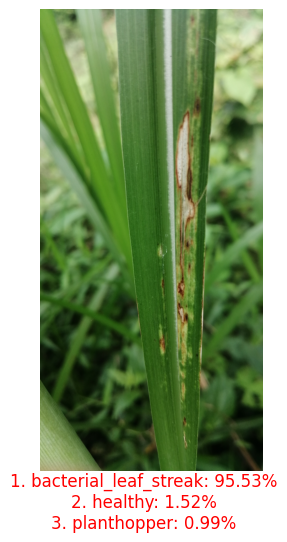

In [ ]:
# Halimbawa: Ipakita ang unang test image prediction
display_predictions(0)

def display_predictions_grid(index):
    """Ipakita ang imahe sa square format sa kaliwa at predictions sa kanan nang walang spacing."""
    image_path = test_generator.filepaths[index]
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # I-resize ang imahe para maging square (adjust as needed)
    target_size = 300
    img = cv2.resize(img, (target_size, target_size))

    top_predictions = [(CLASS_NAMES[c], y_pred[index][c] * 100) for c in y_pred_top3[index]]

    fig = plt.figure(figsize=(8, 4))
    spec = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0)

    ax0 = plt.subplot(spec[0])
    ax0.imshow(img)
    ax0.axis('off')

    ax1 = plt.subplot(spec[1])
    ax1.axis('off')
    text = f"1. {top_predictions[0][0]}: {top_predictions[0][1]:.2f}%\n"
    text += f"2. {top_predictions[1][0]}: {top_predictions[1][1]:.2f}%\n"
    text += f"3. {top_predictions[2][0]}: {top_predictions[2][1]:.2f}%"
    ax1.text(0, 0.5, text, fontsize=12, verticalalignment='center', fontweight='bold', family='monospace')

    plt.show()


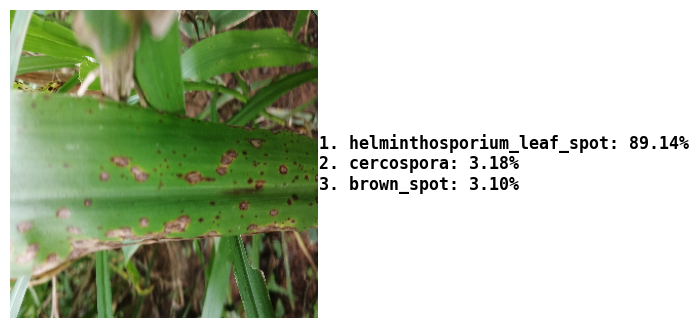

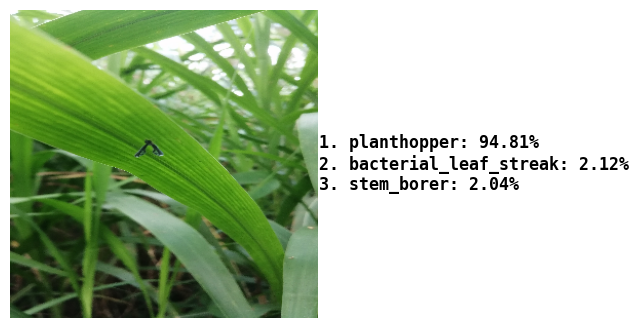

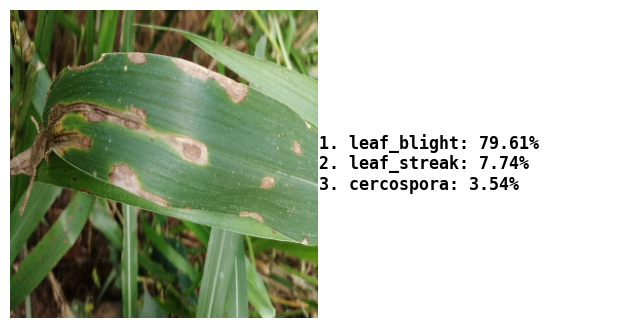

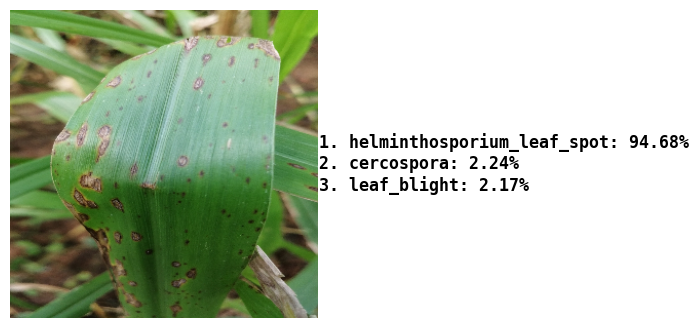

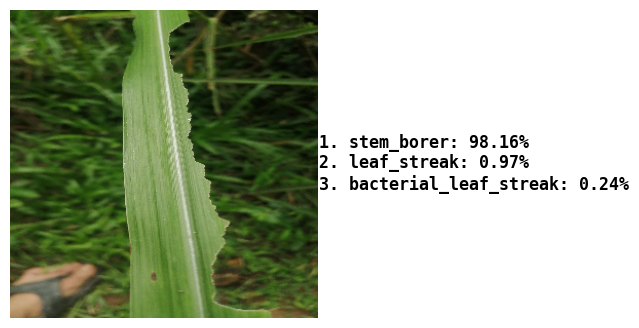

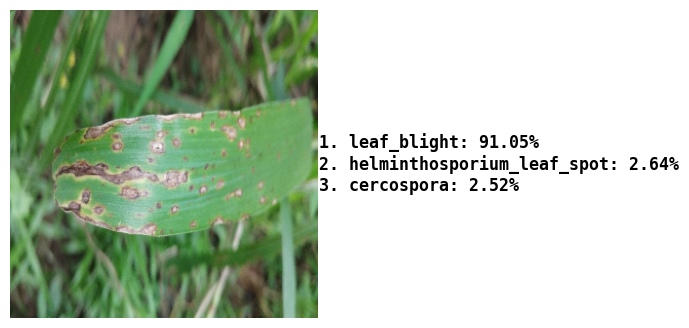

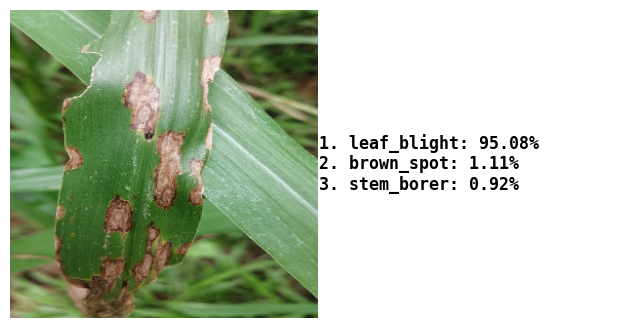

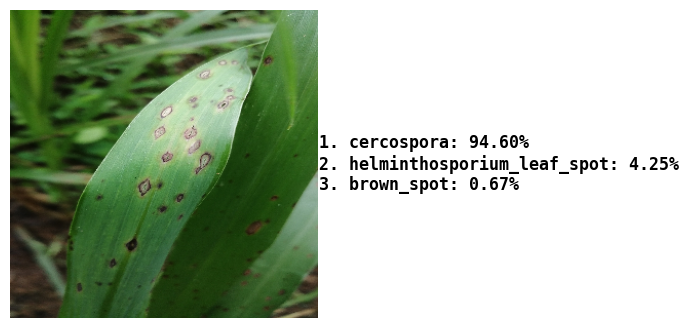

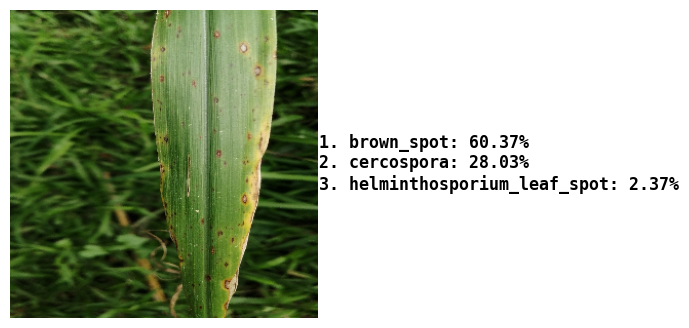

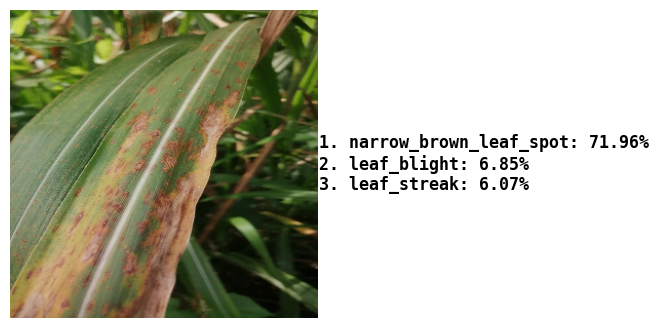

In [ ]:
# Ipakita ang 10 random test images kasama ang predictions
random_indices = random.sample(range(len(test_generator.filepaths)), 10)
for i in random_indices:
    display_predictions_grid(i)


# ======================== #
#       SAVE AT CONVERT    #
# ======================== #

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have y_true (true labels) and y_pred_classes (predicted labels)
report = classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES)

print ('InceptionV3: Classification Report')
print(report)

InceptionV3: Classification Report
                            precision    recall  f1-score   support

     bacterial_leaf_streak       0.94      1.00      0.97        32
                brown_spot       0.88      0.91      0.89        32
                cercospora       0.89      0.97      0.93        32
      curvularia_leaf_spot       0.94      0.94      0.94        32
                   eyespot       1.00      1.00      1.00        32
              fungal_blast       0.90      0.84      0.87        32
helminthosporium_leaf_spot       0.86      0.97      0.91        32
               leaf_blight       1.00      0.91      0.95        32
               leaf_streak       0.97      0.94      0.95        32
    narrow_brown_leaf_spot       1.00      0.91      0.95        32
               planthopper       0.97      0.97      0.97        33
                stem_borer       0.93      0.88      0.90        32
                   healthy       0.97      1.00      0.98        32

           

In [ ]:
# I-save ang final model (InceptionV3 na may fine-tuning)
model.save('/content/drive/MyDrive/the_dataset_napiergrass/inception_v3_modelV5.h5')

# Convert sa TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/content/drive/MyDrive/the_dataset_napiergrass/inception_v3_modelV5.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model converted to TFLite!")


Saved artifact at '/tmp/tmpit_oxbmk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)
Captures:
  135608270241232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135608271693072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135608235524560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135608271697680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135608235524176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135608235525328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135608235526288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135608235525712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135608235524944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135608235525136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1356082355274